# Imports and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from scipy.signal import find_peaks
import glob
import holidays
import datetime as dt
from holidays import country_holidays

pd.set_option('display.max_columns',100)

plt.style.use(('ggplot','fivethirtyeight'))
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

SEED = 321
np.random.seed(SEED)

In [2]:
OUTPUT_FOLDER = 'Data/'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

crimeData = sorted(glob.glob(OUTPUT_FOLDER+'*.csv'))
df = pd.concat([pd.read_csv(f) for f in crimeData])
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...,...
238853,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
238854,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
238855,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
238856,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Date                  datetime64[ns]
 2   Primary Type          object        
 3   Description           object        
 4   Location Description  object        
 5   Arrest                bool          
 6   Domestic              bool          
 7   Beat                  int64         
 8   District              float64       
 9   Ward                  float64       
 10  Latitude              float64       
 11  Longitude             float64       
dtypes: bool(2), datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 662.0+ MB


In [4]:
df.set_index('Date', inplace=True)
df.head()

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020


# Adding Holidays to DF

In [5]:
df['Date'] = df.index.date

allDays = pd.date_range(df['Date'].min(), df['Date'].max())
allDays

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04',
               '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08',
               '2001-01-09', '2001-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', length=8035, freq='D')

In [6]:
USHoli = country_holidays('US')
USHoli

holidays.country_holidays('US')

In [7]:
holidayList = [USHoli.get(day) for day in allDays]
holidayList

["New Year's Day",
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 'Martin Luther King Jr. Day',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 "Washington's Birthday",
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,


In [8]:
ILHoli = country_holidays('US', subdiv='IL')
ILHoli

holidays.country_holidays('US', subdiv='IL')

In [9]:
df['US Holiday'] = [USHoli.get(day) for day in df['Date']]
df['IL Holiday'] = [ILHoli.get(day) for day in df['Date']]
df.head(3)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Date,US Holiday,IL Holiday
Date,,,,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,2001-01-01,New Year's Day,New Year's Day
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,2001-01-01,New Year's Day,New Year's Day
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,2001-01-01,New Year's Day,New Year's Day


# Stakeholder Question: Which district had the most crimes in 2022? Which had the least?

In [10]:
districtDF = df.copy()
districtDF = districtDF.loc['2022',:]
districtDF

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Date,US Holiday,IL Holiday
Date,,,,,,,,,,,,,,
2022-01-01 13:00:00,12582293,THEFT,$500 AND UNDER,RESTAURANT,False,False,121,1.0,42.0,41.881884,-87.640060,2022-01-01,New Year's Day,New Year's Day
2022-01-01 13:00:00,12607313,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,BANK,False,False,811,8.0,23.0,41.787923,-87.769446,2022-01-01,New Year's Day,New Year's Day
2022-01-01 01:00:00,12585671,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,531,5.0,9.0,41.687443,-87.604120,2022-01-01,New Year's Day,New Year's Day
2022-01-01 01:00:00,12592889,OTHER OFFENSE,HARASSMENT BY TELEPHONE,APARTMENT,False,False,412,4.0,8.0,41.734353,-87.585147,2022-01-01,New Year's Day,New Year's Day
2022-01-01 01:00:00,12584977,THEFT,$500 AND UNDER,OTHER (SPECIFY),False,False,1811,18.0,2.0,41.910818,-87.654560,2022-01-01,New Year's Day,New Year's Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 12:50:00,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966,2022-12-31,None,None
2022-12-31 12:50:00,12937822,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669,2022-12-31,None,None
2022-12-31 00:52:00,12937583,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098,2022-12-31,None,None


In [11]:
districtDF = districtDF.groupby(districtDF['District']).count()
districtDF

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,Ward,Latitude,Longitude,Date,US Holiday,IL Holiday
District,,,,,,,,,,,,,
1.0,13044,13044,13044,12986,13044,13044,13044,13044,12533,12533,13044,412,530
2.0,11793,11793,11793,11753,11793,11793,11793,11793,11522,11522,11793,440,560
3.0,11937,11937,11937,11912,11937,11937,11937,11937,11760,11760,11937,431,558
4.0,13931,13931,13931,13905,13931,13931,13931,13931,13734,13734,13931,525,673
5.0,9773,9773,9773,9760,9773,9773,9773,9773,9631,9631,9773,338,431
6.0,14694,14694,14694,14657,14694,14694,14694,14694,14500,14500,14694,543,694
7.0,10319,10319,10319,10305,10319,10319,10319,10319,10172,10172,10319,385,485
8.0,14805,14805,14805,14770,14805,14805,14805,14805,14512,14512,14805,484,624
9.0,10376,10376,10376,10349,10376,10376,10376,10376,10192,10192,10376,400,486


In [12]:
plotDistrict = districtDF['Primary Type'].sort_values(ascending=False)

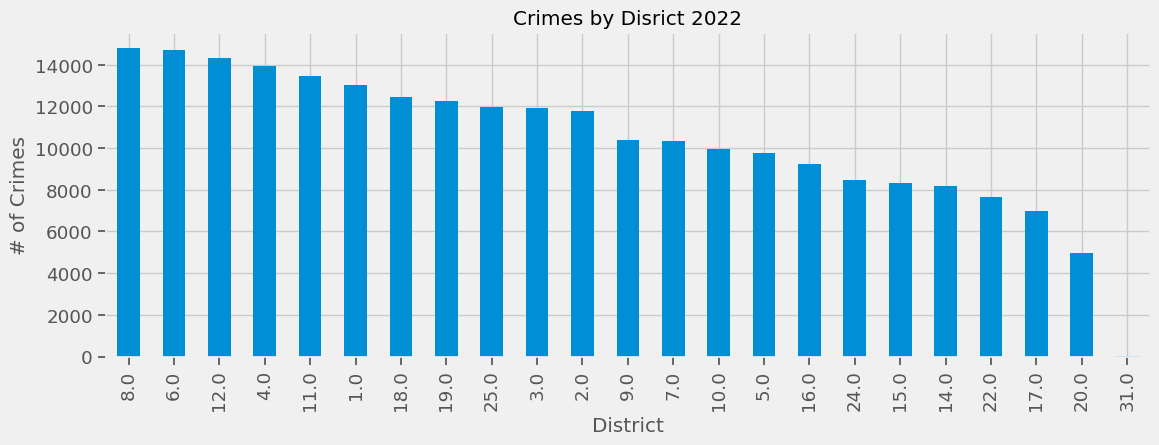

In [13]:
plotDistrict.plot(kind='bar', title='Crimes by Disrict 2022',ylabel='# of Crimes');

Based on the graph above, we can see that District 8 had the highest crime count in 2022, while District 31 had the least. There were only 15 crimes reported in District 31; could this be an error or missing data? We would need to learn more about the district to understand if this is a possibility or just missing data.

# Stakeholder Question: What are the top 3 Holidays for crimes? What are the top 5 crimes on each of those Holidays?

In [14]:
holiCrime = df['IL Holiday'].value_counts().sort_values()

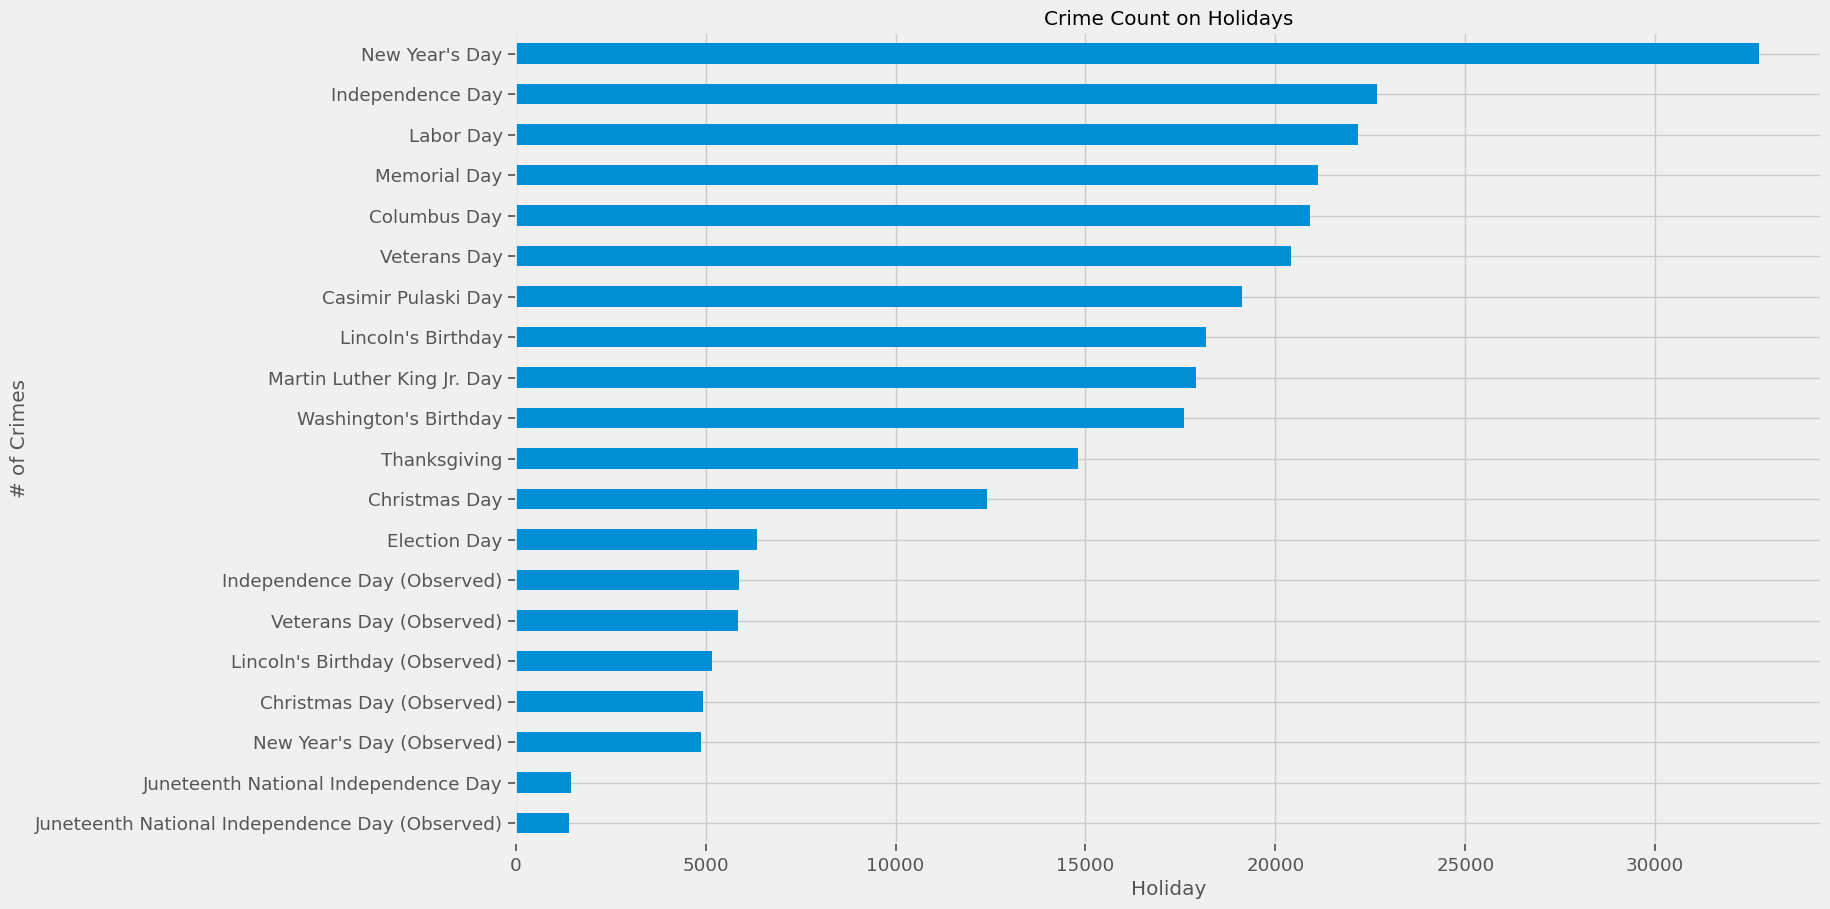

In [15]:
holiCrime.plot(kind='barh', title='Crime Count on Holidays', ylabel='# of Crimes',xlabel='Holiday',figsize=(15,10));

Based on the graph we can see that New Year's Day, Independence Day, and Labor Day have the highest crime rate for holidays.

In [16]:
hcCount = df.copy()
hcCount = hcCount.groupby('IL Holiday')['Primary Type'].value_counts()
hcCount

IL Holiday             Primary Type                     
Casimir Pulaski Day    THEFT                                3992
                       BATTERY                              2904
                       NARCOTICS                            2595
                       CRIMINAL DAMAGE                      1965
                       OTHER OFFENSE                        1558
                                                            ... 
Washington's Birthday  GAMBLING                               12
                       KIDNAPPING                             11
                       INTIMIDATION                           10
                       STALKING                                9
                       CONCEALED CARRY LICENSE VIOLATION       4
Name: Primary Type, Length: 558, dtype: int64

In [20]:
holidays = ["New Year's Day","Independence Day",'Labor Day']
topHoliCrime = hcCount.loc[holidays]
topHoliCrime

IL Holiday      Primary Type                     
New Year's Day  THEFT                                6845
                BATTERY                              6043
                CRIMINAL DAMAGE                      3236
                DECEPTIVE PRACTICE                   2934
                OFFENSE INVOLVING CHILDREN           2380
                                                     ... 
Labor Day       STALKING                               13
                INTIMIDATION                           12
                CONCEALED CARRY LICENSE VIOLATION       5
                OBSCENITY                               5
                OTHER NARCOTIC VIOLATION                1
Name: Primary Type, Length: 87, dtype: int64

In [21]:
topIndC = topHoliCrime['Independence Day'].head(5)
topNewC = topHoliCrime["New Year's Day"].head(5)
topLabC = topHoliCrime['Labor Day'].head(5)

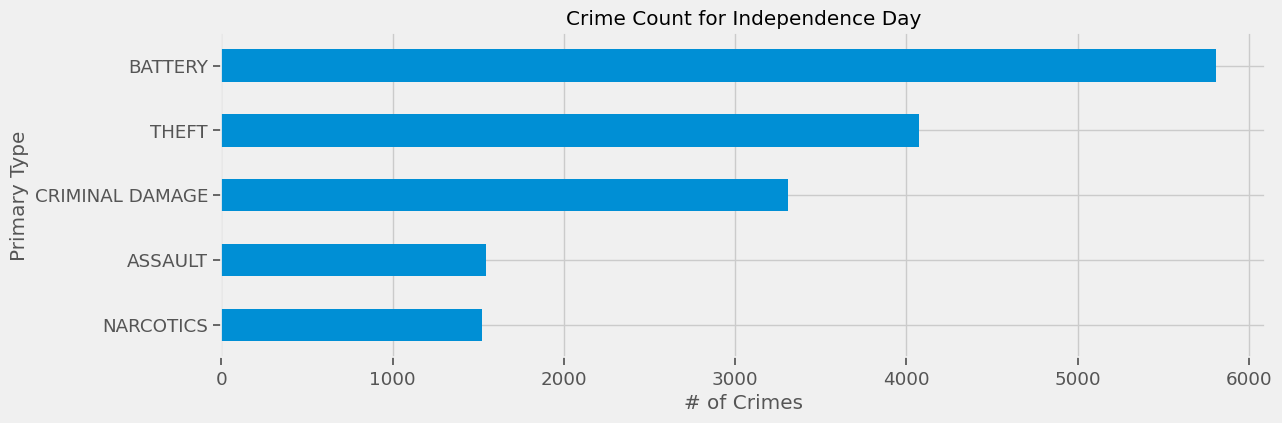

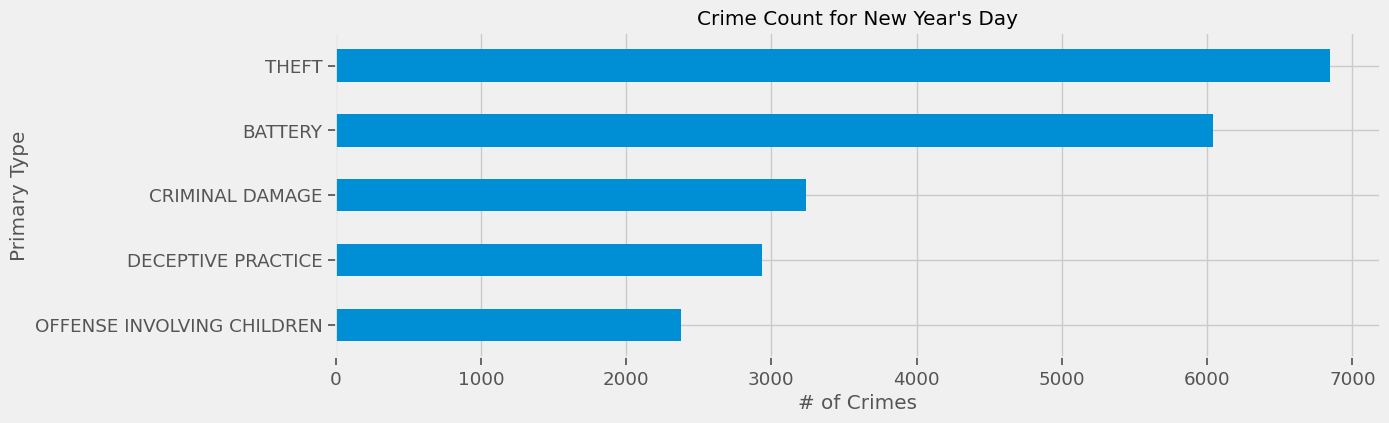

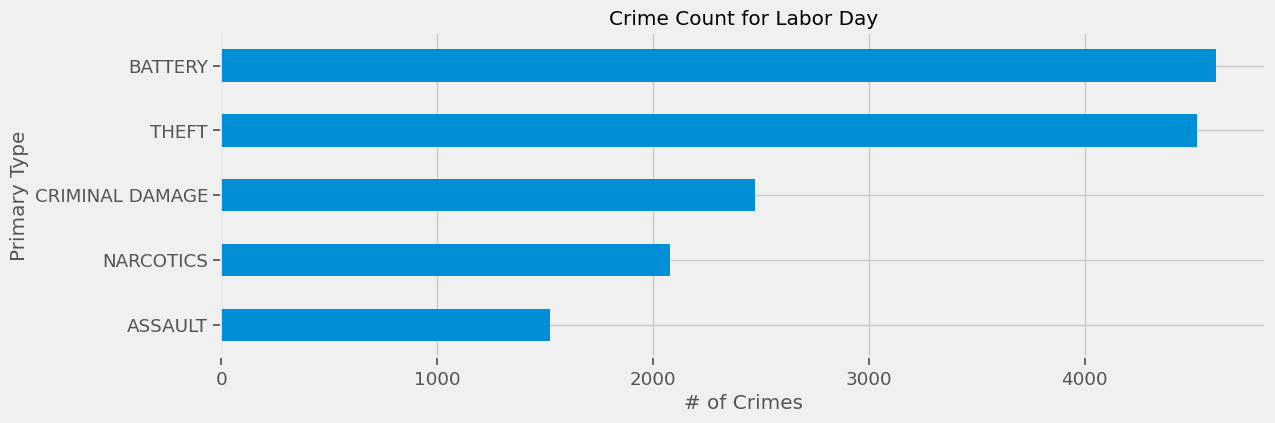

In [22]:
plotData = {'Independence Day':topIndC,"New Year's Day":topNewC,'Labor Day':topLabC}

for h, d in plotData.items():
    sort = d.sort_values(ascending=True)
    sort.plot(kind='barh',title=f'Crime Count for {h}',xlabel='# of Crimes')
    plt.show();

Based on the graphs above we can see the top 5 crimes for each of the top 3 holidays:

New Year's Day: Theft, Battery, Criminal Damage, Deceptive Practice, and Offense Involving Children
Independence Day: Battery, Theft, Criminal Damage, Assault, and Narcotics
Labor Day: Battery, Theft, Criminal Damage, Narcotics, and Assault

# Stakeholder Question: What cycles (seasonality) is there within the data? How long is the period and what is the magnitude?

In [23]:
seasonDF = df.copy()

In [24]:
CRIMEcount = seasonDF['Primary Type'].value_counts().to_frame('Crime Counts')
CRIMEcount

,Crime Counts
THEFT,1626992
BATTERY,1410889
CRIMINAL DAMAGE,878914
NARCOTICS,746155
ASSAULT,501103
OTHER OFFENSE,479174
BURGLARY,422246
MOTOR VEHICLE THEFT,366586
DECEPTIVE PRACTICE,340958
ROBBERY,289677


In [26]:
seasonDF.groupby('Primary Type').count().head(10)

,ID,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Date,US Holiday,IL Holiday
Primary Type,,,,,,,,,,,,,
ARSON,13121,13121,13120,13121,13121,13121,13121,11805,13032,13032,13121,403,466
ASSAULT,501103,501103,501046,501103,501103,501103,501099,461297,498853,498853,501103,13540,16522
BATTERY,1410889,1410889,1410735,1410889,1410889,1410889,1410883,1292519,1404601,1404601,1410889,45336,52959
BURGLARY,422246,422246,422121,422246,422246,422246,422243,389768,420410,420410,422246,11425,13893
CONCEALED CARRY LICENSE VIOLATION,1019,1019,1019,1019,1019,1019,1019,1014,1016,1016,1019,45,53
CRIM SEXUAL ASSAULT,27584,27584,27583,27584,27584,27584,27583,25526,26108,26108,27584,1490,1636
CRIMINAL DAMAGE,878914,878914,878868,878914,878914,878914,878910,807346,874298,874298,878914,27447,32660
CRIMINAL SEXUAL ASSAULT,6353,6353,6343,6353,6353,6353,6353,6337,5496,5496,6353,405,441
CRIMINAL TRESPASS,212869,212869,212865,212869,212869,212869,212869,195367,211815,211815,212869,5536,7099


In [27]:
crimeList = seasonDF['Primary Type'].unique()

crimes = {}

for c in crimeList:
    temp = seasonDF.loc[seasonDF['Primary Type']==c].copy()
    resample = temp.resample('D').size()
    crimes[c] = resample.copy()
crimes.keys()

dict_keys(['BATTERY', 'GAMBLING', 'CRIMINAL DAMAGE', 'OFFENSE INVOLVING CHILDREN', 'THEFT', 'ASSAULT', 'NARCOTICS', 'CRIM SEXUAL ASSAULT', 'DECEPTIVE PRACTICE', 'WEAPONS VIOLATION', 'OTHER OFFENSE', 'MOTOR VEHICLE THEFT', 'SEX OFFENSE', 'BURGLARY', 'PUBLIC PEACE VIOLATION', 'LIQUOR LAW VIOLATION', 'ROBBERY', 'CRIMINAL TRESPASS', 'INTERFERENCE WITH PUBLIC OFFICER', 'HOMICIDE', 'KIDNAPPING', 'PROSTITUTION', 'STALKING', 'INTIMIDATION', 'CRIMINAL SEXUAL ASSAULT', 'ARSON', 'RITUALISM', 'DOMESTIC VIOLENCE', 'OBSCENITY', 'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY', 'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL', 'HUMAN TRAFFICKING', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'NON - CRIMINAL'])

In [28]:
crimeDF = pd.DataFrame(crimes)
crimeDF

,BATTERY,GAMBLING,CRIMINAL DAMAGE,OFFENSE INVOLVING CHILDREN,THEFT,ASSAULT,NARCOTICS,CRIM SEXUAL ASSAULT,DECEPTIVE PRACTICE,WEAPONS VIOLATION,OTHER OFFENSE,MOTOR VEHICLE THEFT,SEX OFFENSE,BURGLARY,PUBLIC PEACE VIOLATION,LIQUOR LAW VIOLATION,ROBBERY,CRIMINAL TRESPASS,INTERFERENCE WITH PUBLIC OFFICER,HOMICIDE,KIDNAPPING,PROSTITUTION,STALKING,INTIMIDATION,CRIMINAL SEXUAL ASSAULT,ARSON,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,OTHER NARCOTIC VIOLATION,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING,NON-CRIMINAL (SUBJECT SPECIFIED),NON - CRIMINAL
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,296,2.0,233,100,412,70,97,38.0,94,32,167,60,65,66,5,3,41,29,1.0,2,2.0,5.0,1,1.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-02,143,1.0,118,4,221,66,175,2.0,78,9,101,65,4,68,2,2,35,35,1.0,0,1.0,11.0,0,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,165,0.0,136,3,226,79,133,7.0,49,7,96,72,5,57,7,2,51,35,0.0,0,3.0,16.0,1,0.0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,173,2.0,133,5,243,57,142,2.0,42,9,96,87,1,55,3,4,55,29,3.0,2,2.0,19.0,0,1.0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,178,0.0,142,9,265,68,185,6.0,53,6,90,86,2,55,5,8,55,29,2.0,1,3.0,16.0,0,0.0,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,76,NaN,64,4,147,47,9,NaN,40,12,33,77,2,17,1,1,27,20,1.0,0,0.0,NaN,1,0.0,4,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2022-12-28,102,NaN,78,3,112,44,12,NaN,38,17,38,103,0,23,1,0,28,12,0.0,1,0.0,NaN,1,0.0,4,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2022-12-29,97,NaN,95,3,137,38,15,NaN,38,11,37,95,3,29,2,0,28,12,1.0,2,1.0,NaN,1,1.0,1,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [29]:
crimeDF = crimeDF.fillna(0)

In [30]:
crimeDF = crimeDF[['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT',
       'OTHER OFFENSE', 'BURGLARY', 'MOTOR VEHICLE THEFT',
       'DECEPTIVE PRACTICE', 'ROBBERY']]

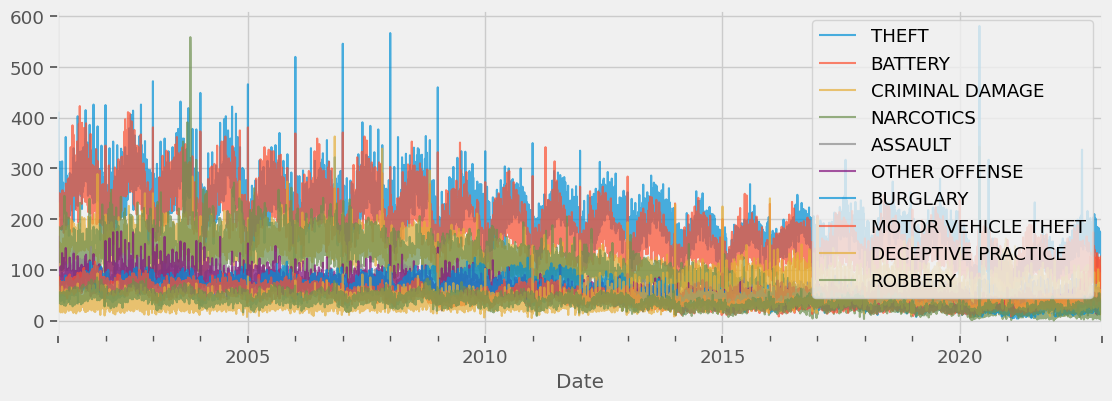

In [31]:
crimeDF.plot(alpha=0.7);

This is a lot of data to try and visualize all in one snap shot. I will zoom in and just look at the last 5 years (2018-2022)

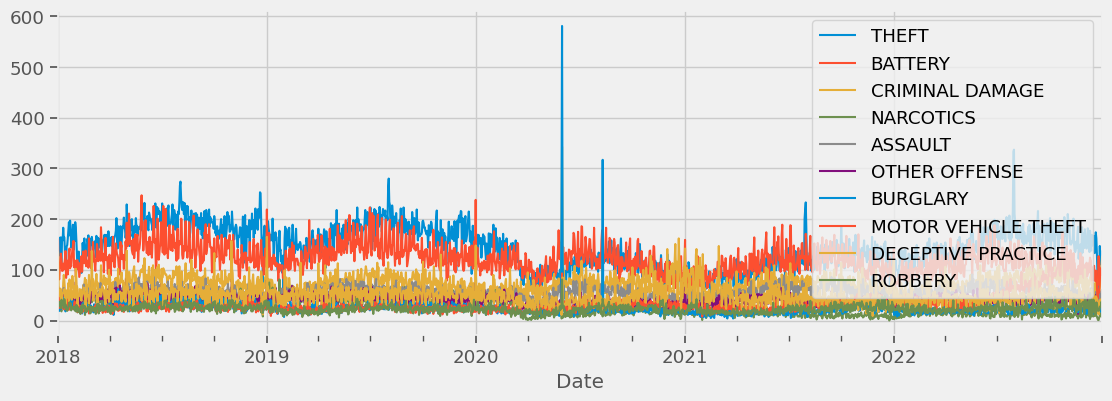

In [32]:
plot = crimeDF.loc['2018':'2022']
ax = plot.plot()
ax.legend(loc='upper right');

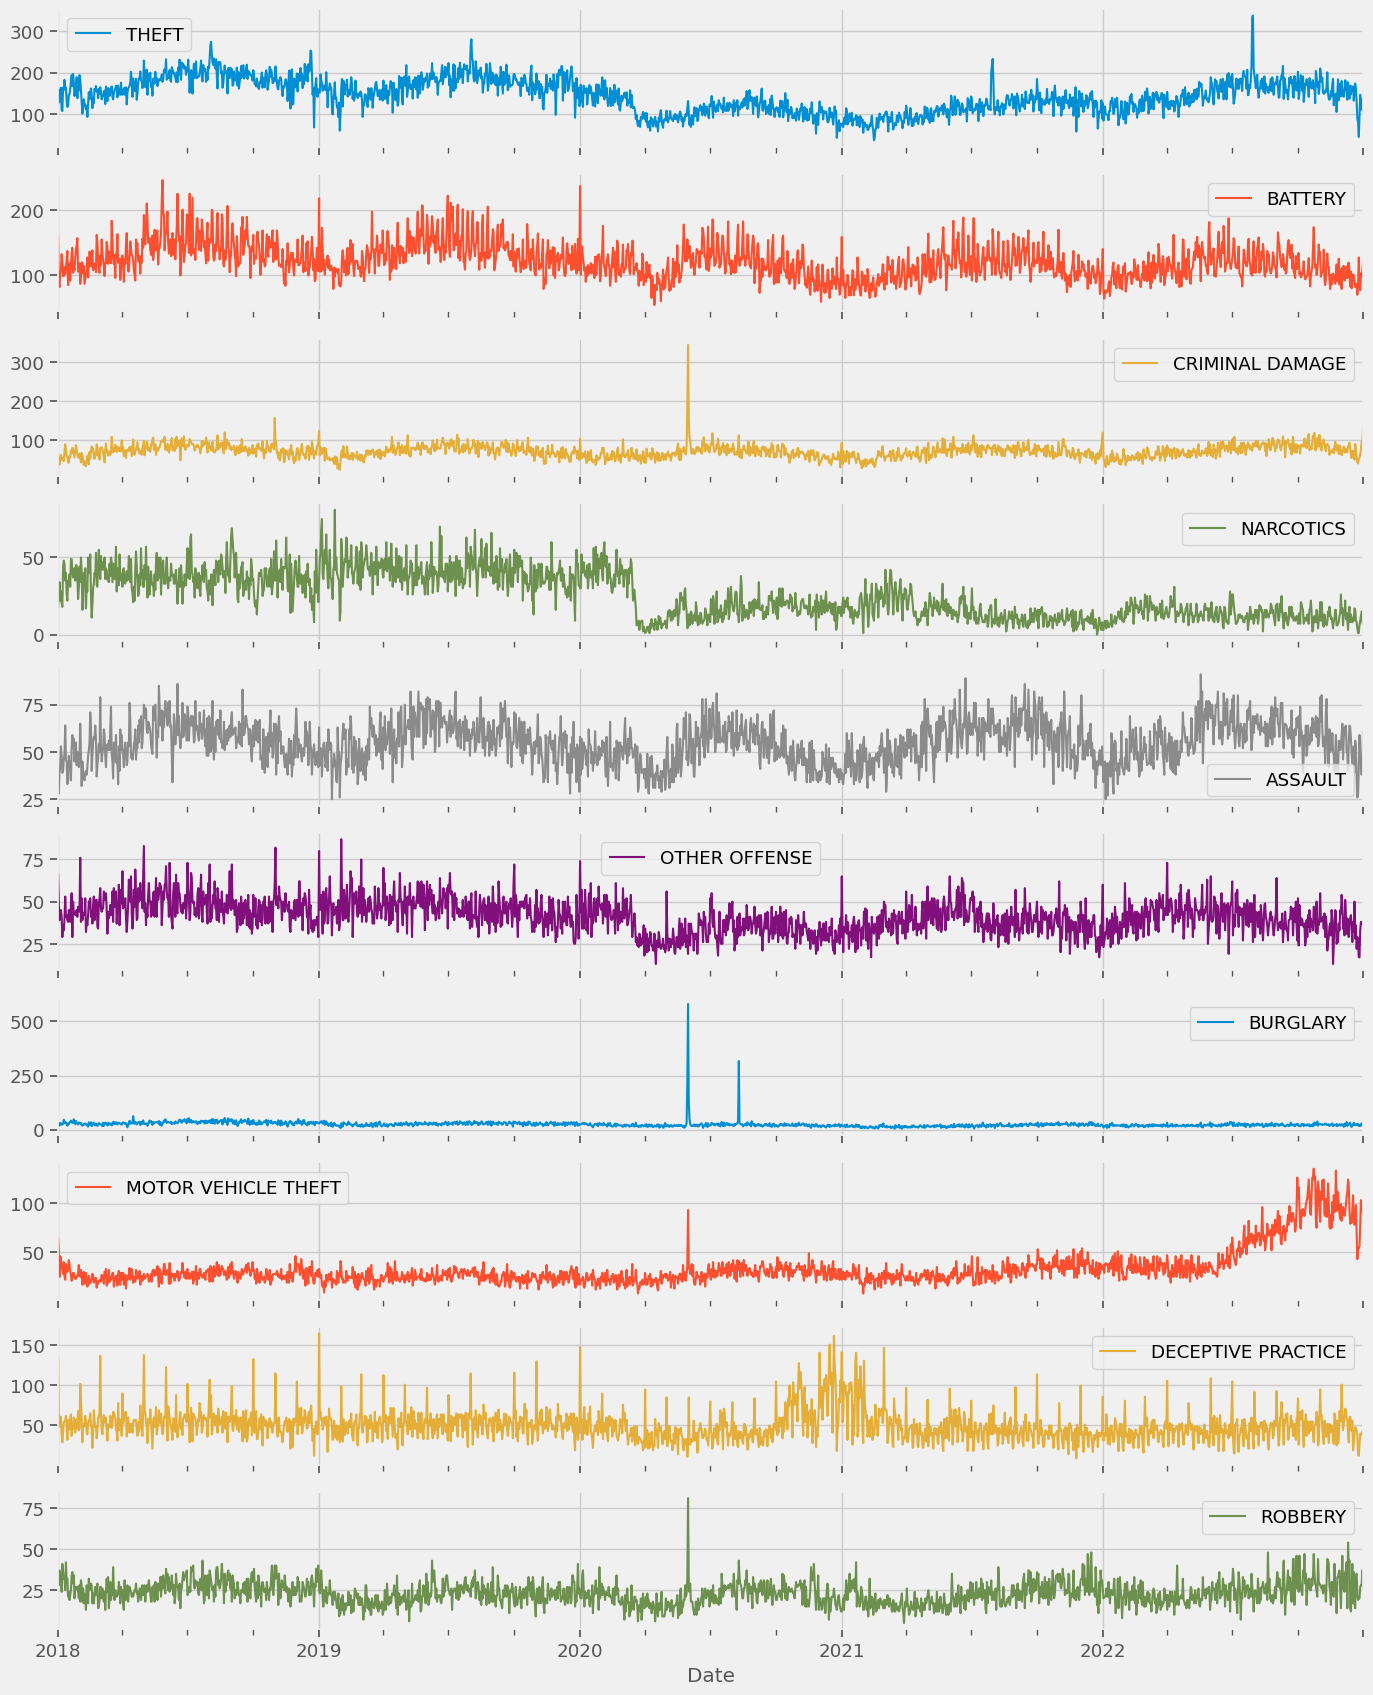

In [33]:
plot.plot(subplots=True, figsize=(15,20));

I will go ahead and try to resample the data again into weekly and apply a moving average. This will help better visualize if there is any seasonality in the data.

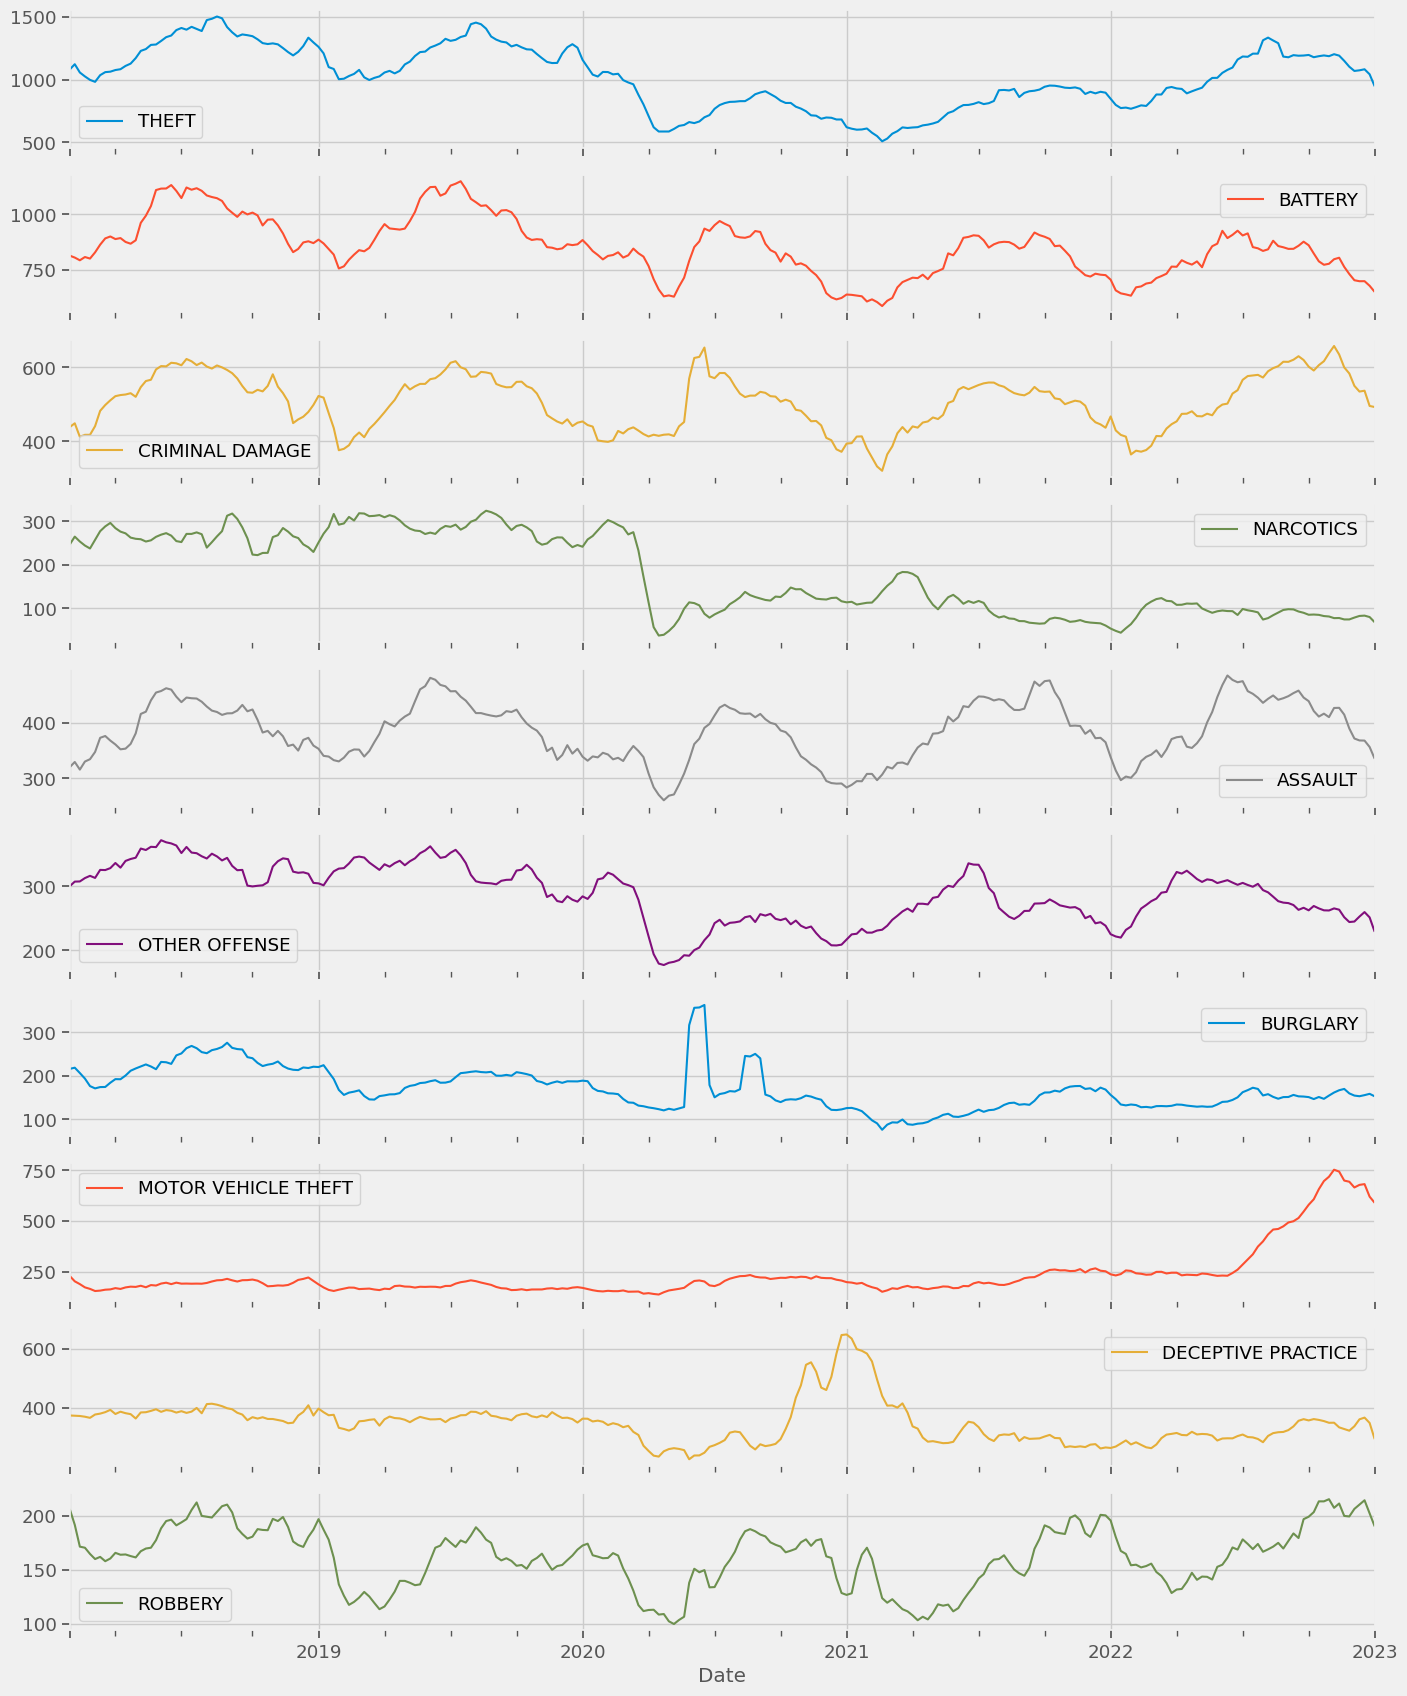

In [34]:
plotW = crimeDF.loc['2018':'2022'].resample('W').sum()
plotW.rolling(4).mean().dropna().plot(subplots=True, figsize=(15,20));

Looking at the subplots, it appears there may be some seasonality in:

Battery, Criminal Damage, Assault, and Robbery.

I will dive deeper into the Robbery to see what the seasonality looks like for that crime type.

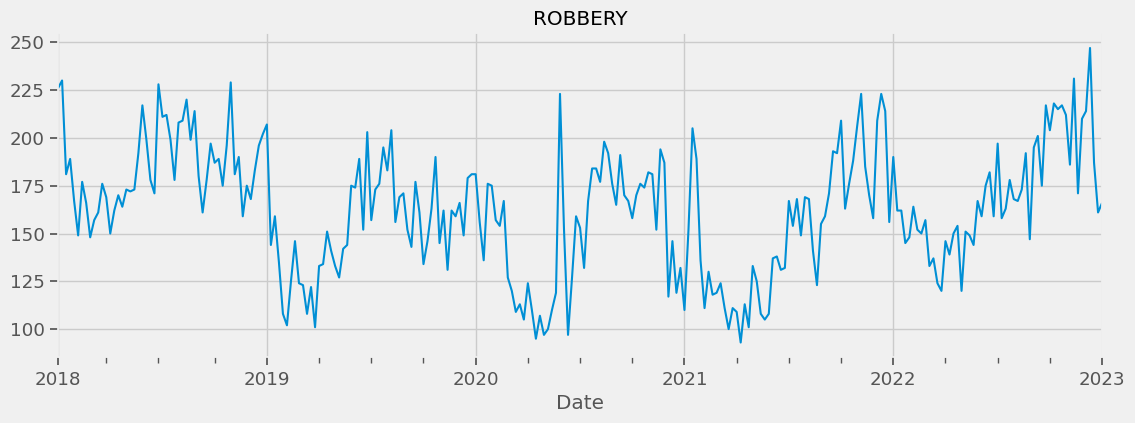

In [35]:
crimeT = 'ROBBERY'

sd = plotW[crimeT]
sd.plot(title=crimeT);

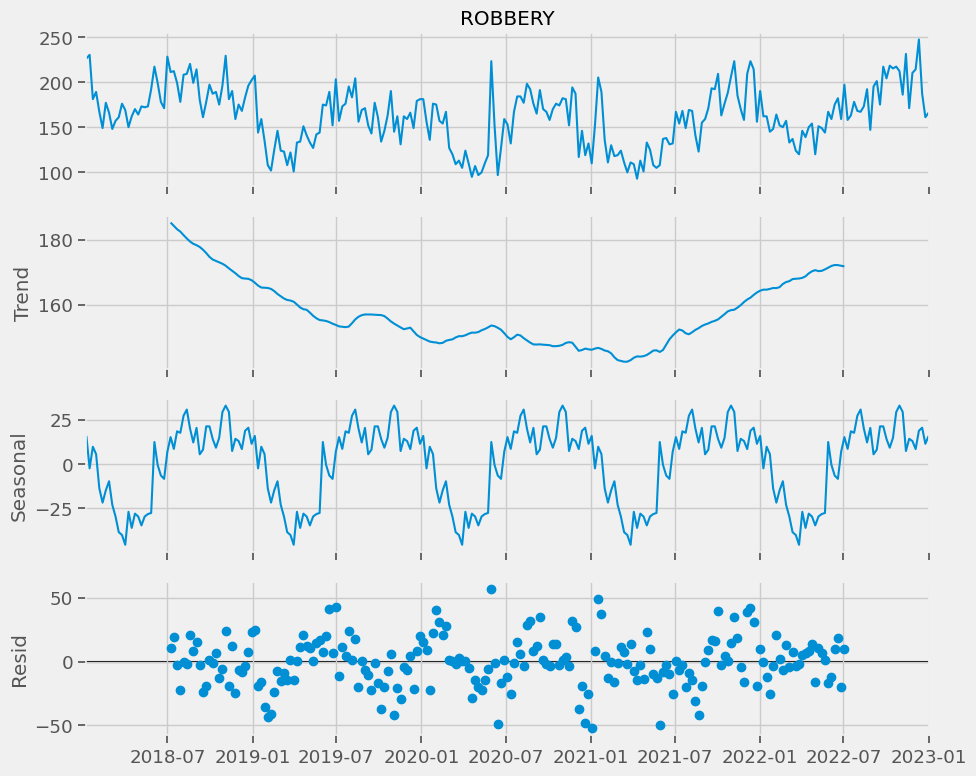

In [36]:
decomp = tsa.seasonal_decompose(sd)

fig = decomp.plot()
fig.set_size_inches(10,8)
fig.tight_layout();

Looking at the graphs above, we can see the trend is taking a u shape, meaning that robbery was seeing a slight decline and semi-flattened out before starting a steady increase.

We can also observe that the seasonal component shows that there seems to be some pattern in the number of robberies throughout the weeks of the year.

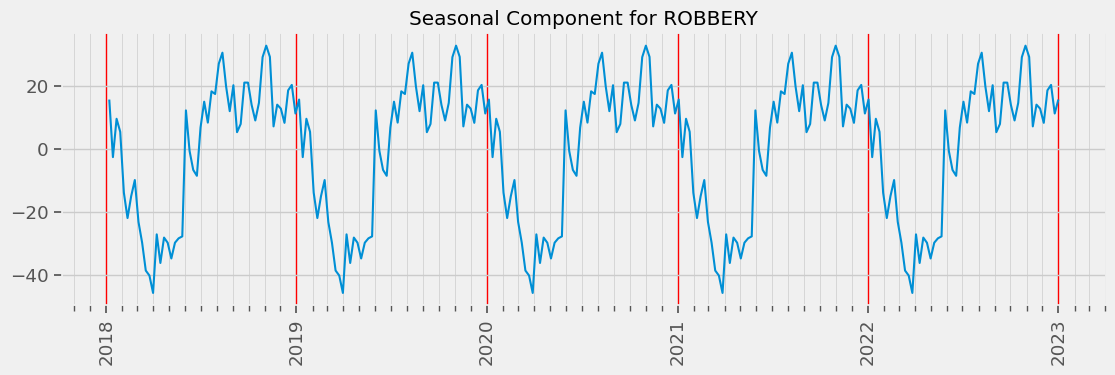

In [37]:
season = decomp.seasonal
minorLoc = mdates.MonthLocator()

fig,ax = plt.subplots()
ax.plot(season)
ax.xaxis.set_minor_locator(minorLoc)
ax.set(title=f'Seasonal Component for {crimeT}')
ax.grid(which='major', axis='x', lw=1, color='red')
ax.grid(which='minor', axis='x', lw=0.5)
fig.autofmt_xdate(rotation=90, ha='center');

This graph shows there is, in fact, a tendency to increase in robbery in the middle and heading into the end of the year. However, robbery is steeply dropped at the start of the year (Jan-March). This could be due to freezing weather in Chicago at this time of year.

In [38]:
# Looking at magnitude of season
mag = season.max() - season.min()
mag

78.77163461538463

In [39]:
def  plot_seasonal(season):
    minor_loc = mdates.MonthLocator()
    fig, ax = plt.subplots()
    ax.plot(season)
    ax.set(title=f'Seasonal Componet for {crimeT}');
    
    ax.xaxis.set_minor_locator(minor_loc)
    ax.grid(which='major',axis='x',lw=1,color='red')
    ax.grid(which='minor',axis='x',lw=0.5)
    fig.autofmt_xdate(rotation=90,ha='center')
    
    return fig, ax

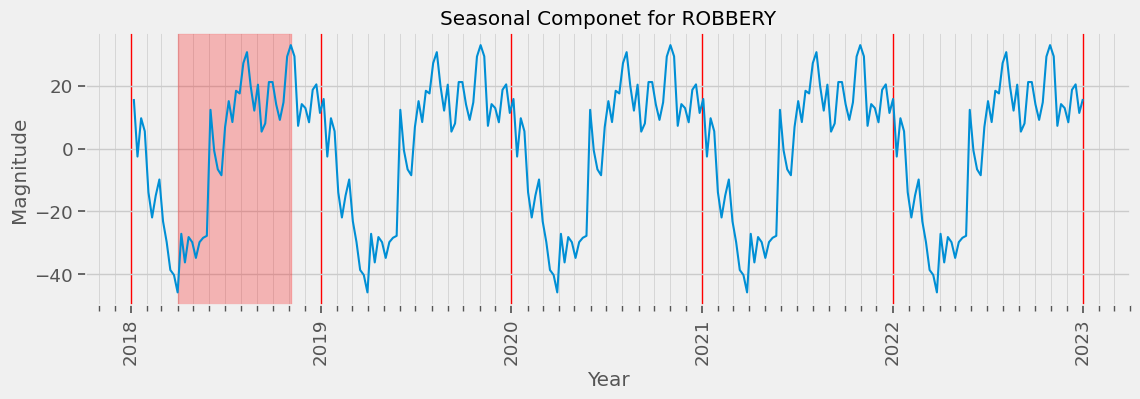

In [40]:
fig,ax = plot_seasonal(season)
ax.set(ylabel='Magnitude',xlabel='Year')
ax.axvspan(season.idxmin(),season.idxmax(),color='red',alpha=0.25);

In [41]:
tdelta = season.idxmax() - season.idxmin()
tdelta

Timedelta('217 days 00:00:00')

So we now know that the min to the peak level of the robbery crime type is 217 days. Our magnitude of the season is 78.77.

In [42]:
peaks, props = find_peaks(season, height=season.max())
pDate = season.index[peaks]
period = pDate[1]-pDate[0]

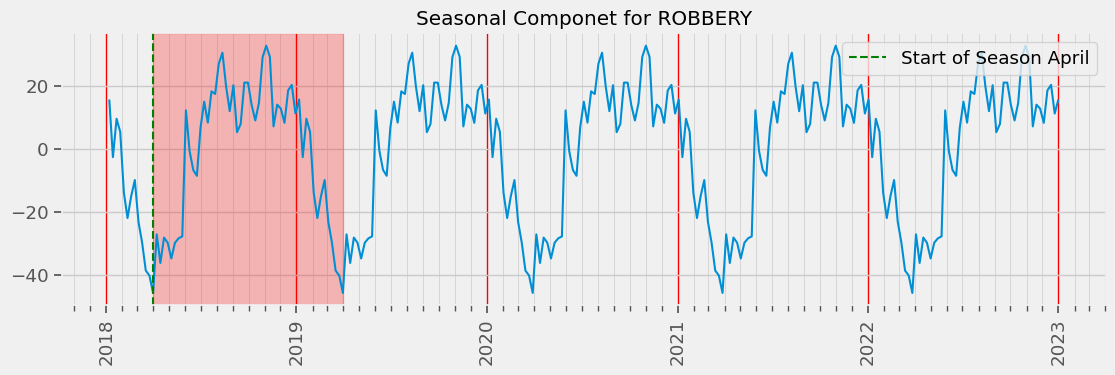

In [43]:
fig, ax = plot_seasonal(season)
seasonStart = season.idxmin()
ax.axvspan(seasonStart, seasonStart+period,color='red',alpha=0.25)
ax.axvline(seasonStart, color='green', ls='--',
           label=f"Start of Season {seasonStart.strftime('%B')}")
ax.legend(loc='upper right');

In [44]:
period

Timedelta('364 days 00:00:00')

The graph above now shows us the full period instead of the season. Our season seems to start in April (this is when we start to see the increase in robbery crimes), and a full period is shown as 364 days (one year).